In [1]:
#Needed in general
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC 


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print(fs)


import seaborn as sns

24


In [ ]:
s = r'$\Chi$'

print(s)

In [ ]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    

    
    DCOtype='BHNS'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
#     print(fdata['doubleCompactObjects'].keys())
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1
    
    
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 


    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 


    maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )  
    print('sum NS-BH mask = ', np.sum(maskNSBH))

    print('sum mask = ', np.sum(maskSNdco))

    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    print(spinBH)
    
        
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$\rm{M}_{\rm{chirp}}$', r'$\rm{M}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{M}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
           r'$q $', r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']              
    varlist = [Chirpmass, M1, M2, MassRatio, spinBH]
    
    print(len(w))
    fraction = np.sum(w[maskNSBH]) / np.sum(w)
    print('fraction=', fraction)
    
    
    maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
    maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
    fs_l = 20 # label fontsize
    
    cGW1 = 'lightskyblue' 
    cGW0 = 'orange'
    LEGEND = True 
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 100)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
                
                if param_x==r'$q $':
                    xx = [-100, -50]
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
                    ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)
                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                N=1000 # temp 
                ax[ii,jj].scatter(varlist[jj][0:], varlist[ii][0:], s=140*w[0:], color='lightgray', zorder=1)
                ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
                ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)
                
                if (ii==(len(var)-1)):
                    print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 

labellist=[ r'$M_{\rm{chirp}}$', r'$M_{\rm{BH}} \ [M_{\odot}]$', r'$M_{\rm{NS}} \ [M_{\odot}]$',\
           r'$q $', r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'
plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_Final_spin_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()






ii,jj= 0 0
ii,jj= 1 0
ii,jj= 2 0
ii,jj= 3 0
ii,jj= 4 0
4
ii,jj= 1 1
ii,jj= 2 1
ii,jj= 3 1
ii,jj= 4 1
4
ii,jj= 2 2
ii,jj= 3 2
ii,jj= 4 2
4
ii,jj= 3 3
ii,jj= 4 3
4
ii,jj= 4 4


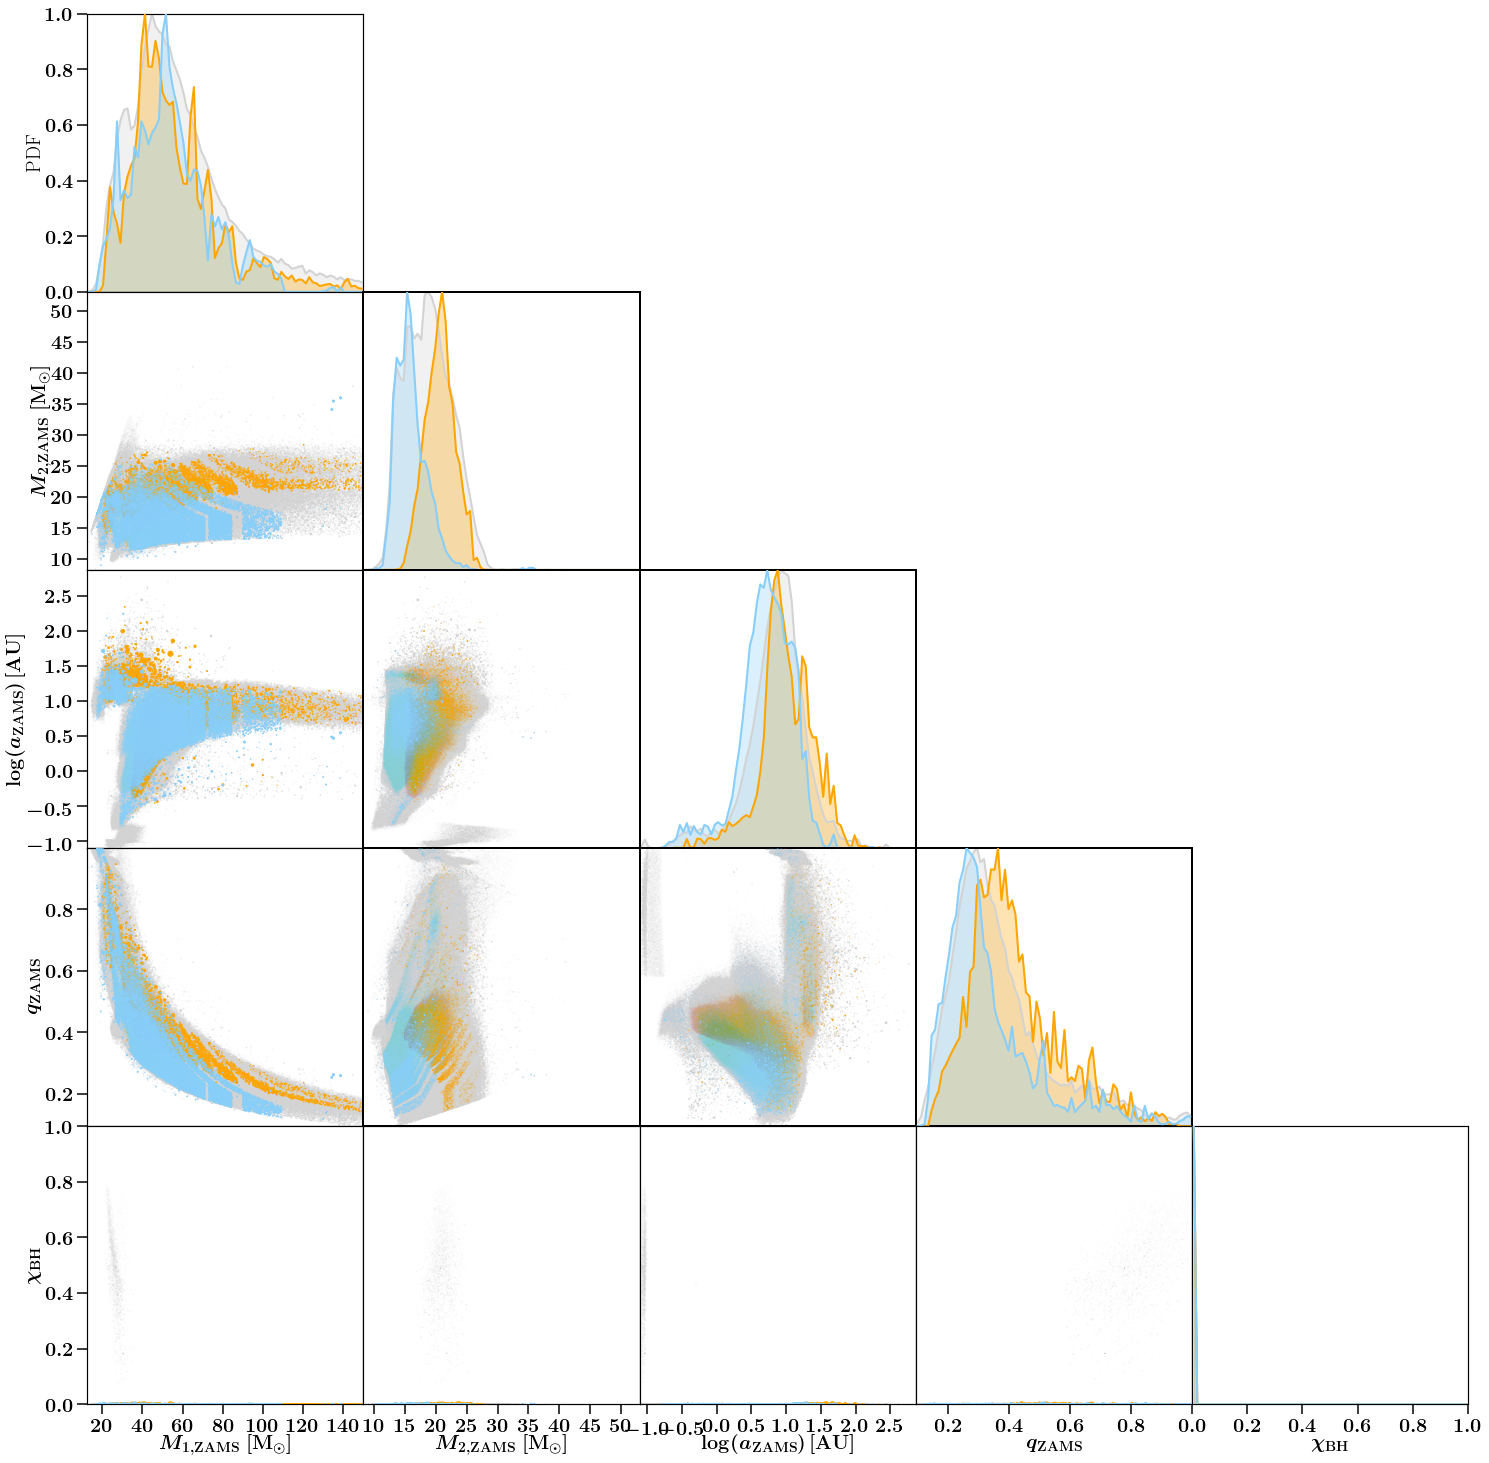

In [5]:
fs=20
def plot2DdistributionScatter(axe, var, BPSmodelName='A'):
    
    DCOtype='BHNS'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path)
    
    
    # M1 will be the most massive, M2 the least massive compact object. 
    M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    Chirpmass = chirpmass(M1, M2)
    MassRatio = M2/M1

    ### FOR SPIN ###
    
    
    seedsDCO = fdata['doubleCompactObjects']['seed'][...].squeeze()
    seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
    # get only SN seeds for DCOs 
    maskSNdco = np.in1d(seedsSN,  seedsDCO) 
    whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
    whichSN1 = whichSN[::2] # get whichStar for first SN 

    separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
    separationPreSN2 = separationPreSN[1::2] # in Rsun. 


    maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )  

    spinBH = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    
    ### read in MSSFR weights: ###
    mssfr = '112' # mssfr that matches LIGO observed rates.
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    w = fdata[fparam_key][weightheader][...].squeeze()
        
    labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
           r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']      
    
    
    
    M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    separationInitial = np.log10(fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
    Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
    massRatio = M2ZAMS / M1ZAMS 
    
    varlist = [M1ZAMS, M2ZAMS, separationInitial, massRatio, spinBH]
    
    
    
    maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
    maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 
    
    fs_l = 20 # label fontsize
    
    cGW1 = 'lightskyblue' 
    cGW0 = 'orange'
    LEGEND = True 
    for jj, param_x in enumerate(var):
        jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

        for ii, param_y in enumerate(var):

            ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
            if ii==jj:
                nrbins=np.linspace(jj_minn, jj_maxx, 80)
                hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)
                
                hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
                yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
                xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
                axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
                axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)
                
                ylabel='PDF'
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(0,1)
                
                if param_x==r'$q $':
                    xx = [-100, -50]
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
                    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
                    ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.7, 0.9), frameon=False)
                    

                if jj==(len(var)-1):
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                    

                if ii!=0:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 
                    
                if ii==0:
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY='PDF', setMinor=False, labelpad=10, fontsize=fs_l)

            elif jj>ii:
                ax[ii,jj].set_axis_off()                    

            else:
                print('ii,jj=', ii, jj)
                axe[ii,jj].set_xlim(jj_minn, jj_maxx)
                axe[ii,jj].set_ylim(ii_minn, ii_maxx)
                if (ii ==4) | (jj==0):
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=4400*w[maskGW200105], color='orange', zorder=10)
                    ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=4400*w[maskGW200115], color='lightskyblue', zorder=10)
                
                else:
                    ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
                    ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
                    ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)

                if (ii==(len(var)-1)):
                    print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
                if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
                    ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)
                    
                else:
                    axe[ii,jj].set_yticks([])
                    axe[ii,jj].set_yticklabels( () ) 


labellist=[ r'$M_{\rm{1,ZAMS}} \ [\rm{M}_{\odot}]$', r'$M_{\rm{2,ZAMS}} \ [\rm{M}_{\odot}]$',\
       r'$\log(a_{\rm{ZAMS}})\, [\rm{AU}]$', r'$q_{\rm{ZAMS}}$',  r'$\chi_{\rm{BH}}$'] #,  r'$\log_{10}(t) $']                      
                    
                    
f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)
model='P'

plot2DdistributionScatter(axe=ax, var=labellist, BPSmodelName=model)
plt.savefig('./Scatter_ZAMS_Spin2_' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()

In [ ]:
fs=20


labellist=[ r'$M_{\rm{chirp}}$', r'$M_{\rm{BH}} \ [M_{\odot}]$', r'$M_{\rm{NS}} \ [M_{\odot}]$',\
           r'$q $', '\Chi_{\rm{BH}}'] #,  r'$\log_{10}(t) $']     
f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(20,20), 
                  gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})

mssfr = '112' # mssfr that matches LIGO observed rates.
model='P'
axe=ax
var=labellist
BPSmodelName=model    
    
# #########################



DCOtype='BHNS'
# path for files 
path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

# read in data 
fdata = h5.File(path)


# M1 will be the most massive, M2 the least massive compact object. 
M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
Chirpmass = chirpmass(M1, M2)
MassRatio = M2/M1

### read in MSSFR weights: ###
mssfr = '112' # mssfr that matches LIGO observed rates.
# get detected weights
fparam_key = 'weights_detected'
weightheader = 'w_' + mssfr
w = fdata[fparam_key][weightheader][...].squeeze()

labellist=[ r'$\rm{M}_{\rm{chirp}}$', r'$\rm{M}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{M}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
r'$q $'] #,  r'$\log_{10}(t) $']              
varlist = [Chirpmass, M1, M2, MassRatio]


maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35)))
maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) 

fs_l = 20 # label fontsize

cGW1 = 'lightskyblue' 
cGW0 = 'orange'
LEGEND = True 
for jj, param_x in enumerate(var):
jj_minn,jj_maxx = min(varlist[jj]), max(varlist[jj])

for ii, param_y in enumerate(var):

ii_minn,ii_maxx = min(varlist[ii]), max(varlist[ii])
if ii==jj:
    nrbins=np.linspace(jj_minn, jj_maxx, 100)
    hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
    yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
    xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
    axe[ii,jj].plot(xx, yy, color='lightgray', lw=2, zorder=2)
    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.3)

    hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
    yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
    xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
    axe[ii,jj].plot(xx, yy, color=cGW0, lw=2, zorder=3)   
    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=2, alpha=0.3)

    hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
    yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
    xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
    axe[ii,jj].plot(xx, yy, color=cGW1, lw=2, zorder=3)  
    axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=2, alpha=0.3)

    ylabel='PDF'
    print('ii,jj=', ii, jj)
    axe[ii,jj].set_xlim(jj_minn, jj_maxx)
    axe[ii,jj].set_ylim(0,1)

    if param_x==r'$q $':
        xx = [-100, -50]
        axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.3, label='All BHNS')
        axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
        axe[ii,jj].fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
#                     ax[ii,jj].set_legend(fontsize=24, loc='top right')
        ax[ii,jj].legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)


    if jj==(len(var)-1):
        ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)


    if ii!=0:
        axe[ii,jj].set_yticks([])
        axe[ii,jj].set_yticklabels( () ) 

    if ii==0:
        ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l)

elif jj>ii:
    ax[ii,jj].set_axis_off()                    

else:
    print('ii,jj=', ii, jj)
    axe[ii,jj].set_xlim(jj_minn, jj_maxx)
    axe[ii,jj].set_ylim(ii_minn, ii_maxx)


    x = varlist[jj] #np.linspace(0,1,100)
    y = np.ones_like(varlist[jj])
    print(np.shape(varlist[jj]))
    print(np.shape(x))
    N = 10000
    sns.kdeplot(varlist[jj][0:N], varlist[ii][0:N], weights=w[0:N], ax=ax[ii, jj], fill=True, color='gray')# , levels=[0.5, 0.68, 0.98], bw_method=10)

#                 ax[ii,jj] = sns.kdeplot(x=varlist[jj], y=varlist[ii], fill=True, color='r', shade=True, Label='Iris_Setosa',
#             cmap="Reds", shade_lowest=False)
#                 ax[ii,jj].scatter(varlist[jj], varlist[ii], s=140*w, color='lightgray', zorder=1)
#                 ax[ii,jj].scatter(varlist[jj][maskGW200105], varlist[ii][maskGW200105], s=140*w[maskGW200105], color='orange', zorder=10)
#                 ax[ii,jj].scatter(varlist[jj][maskGW200115], varlist[ii][maskGW200115], s=140*w[maskGW200115], color='lightskyblue', zorder=10)

    if (ii==(len(var)-1)):
        print(ii)
#                     ax[ii,jj].set_xlabel(labellist[jj], fontsize=fs)
        ax[ii,jj] == layoutAxesNoYlabel(ax[ii,jj], nameX=labellist[jj], nameY='NA', setMinor=False, labelpad=10, fontsize=fs_l)
    if jj==0:
#                     ax[ii,jj].set_ylabel(labellist[ii], fontsize=fs)
        ax[ii,jj] == layoutAxesNoXlabel(ax[ii,jj], nameX='NA', nameY=labellist[ii], setMinor=False, labelpad=10, fontsize=fs_l)

    else:
        axe[ii,jj].set_yticks([])
        axe[ii,jj].set_yticklabels( () ) 




plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

plt.savefig('./Scatter_Final_kde' + mssfr +'_'  + model+ '.png', transparent=False, bbox_inches="tight")
plt.show()




